The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.0


# Training on Multiple GPUs
:label:`sec_multi_gpu`

So far we discussed how to train models efficiently on CPUs and GPUs. We even showed how deep learning frameworks such as MXNet (and TensorFlow) allow one to parallelize computation and communication automatically between them in :numref:`sec_auto_para`. Lastly, we showed in :numref:`sec_use_gpu` how to list all available GPUs on a computer using `nvidia-smi`. What we did *not* discuss is how to actually parallelize deep learning training (we omit any discussion of *inference* on multiple GPUs here as it is a rather rarely used and advanced topic that goes beyond the scope of this book). Instead, we implied in passing that one would somehow split the data across multiple devices and make it work. The present section fills in the details and shows how to train a network in parallel when starting from scratch. Details on how to take advantage of functionality in Gluon is relegated to :numref:`sec_multi_gpu_concise`. We assume that the reader is familiar with minibatch SGD algorithms such as the ones described in :numref:`sec_minibatch_sgd`.

## Splitting the Problem

Let us start with a simple computer vision problem and a slightly archaic network, e.g., with multiple layers of convolutions, pooling, and possibly a few dense layers in the end. That is, let us start with a network that looks quite similar to LeNet :cite:`LeCun.Bottou.Bengio.ea.1998` or AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`. Given multiple GPUs (2 if it is a desktop server, 4 on a g4dn.12xlarge, 8 on an AWS p3.16xlarge, or 16 on a p2.16xlarge), we want to partition training in a manner as to achieve good speedup while simultaneously benefitting from simple and reproducible design choices. Multiple GPUs, after all, increase both *memory* and *compute* ability. In a nutshell, we have a number of choices, given a minibatch of training data that we want to classify.

* We could partition the network layers across multiple GPUs. That is, each GPU takes as input the data flowing into a particular layer, processes data across a number of subsequent layers and then sends the data to the next GPU.
    * This allows us to process data with larger networks when compared to what a single GPU could handle.
    * Memory footprint per GPU can be well controlled (it is a fraction of the total network footprint)
    * The interface between layers (and thus GPUs) requires tight synchronization. This can be tricky, in particular if the computational workloads are not properly matched between layers. The problem is exacerbated for large numbers of GPUs.
    * The interface between layers requires large amounts of data transfer (activations, gradients). This may overwhelm the bandwidth of the GPU buses.
    * Compute intensive, yet sequential operations are nontrivial to partition. See e.g., :cite:`Mirhoseini.Pham.Le.ea.2017` for a best effort in this regard. It remains a difficult problem and it is unclear whether it is possible to achieve good (linear) scaling on nontrivial problems. We do not recommend it unless there is excellent framework / OS support for chaining together multiple GPUs.
* We could split the work required by individual layers. For instance, rather than computing 64 channels on a single GPU we could split up the problem across 4 GPUs, each of which generate data for 16 channels. Likewise, for a dense layer we could split the number of output neurons. :numref:`fig_alexnet_original` illustrates this design. The figure is taken from :cite:`Krizhevsky.Sutskever.Hinton.2012` where this strategy was used to deal with GPUs that had a very small memory footprint (2GB at the time).
    * This allows for good scaling in terms of computation, provided that the number of channels (or neurons) is not too small.
    * Multiple GPUs can process increasingly larger networks since the memory available scales linearly.
    * We need a *very large* number of synchronization / barrier operations since each layer depends on the results from all other layers.
    * The amount of data that needs to be transferred is potentially even larger than when distributing layers across GPUs. We do not recommend this approach due to its bandwidth cost and complexity.
    
![Model parallelism in the original AlexNet design due to limited GPU memory.](../img/alexnet-original.svg)
:label:`fig_alexnet_original`
    
* Lastly we could partition data across multiple GPUs. This way all GPUs perform the same type of work, albeit on different observations. Gradients are aggregated between GPUs after each minibatch.
    * This is the simplest approach and it can be applied in any situation.
    * Adding more GPUs does not allow us to train larger models.
    * We only need to synchronize after each minibatch. That said, it is highly desirable to start exchanging gradients parameters already while others are still being computed.
    * Large numbers of GPUs lead to very large minibatch sizes, thus reducing training efficiency.

By and large, data parallelism is the most convenient way to proceed, provided that we have access to GPUs with sufficiently large memory. See also :cite:`Li.Andersen.Park.ea.2014` for a detailed description of partitioning for distributed training. GPU memory used to be a problem in the early days of deep learning. By now this issue has been resolved for all but the most unusual cases. We focus on data parallelism in what follows.


## Data Parallelism

Assume that there are $k$ GPUs on a machine. Given the model to be trained, each GPU will maintain a complete set of model parameters independently. Training proceeds as follows (see :numref:`fig_data_parallel` for details on data parallel training on two GPUs).

![Calculation of minibatch stochastic gradient using data parallelism and two GPUs. ](../img/data-parallel.svg)
:label:`fig_data_parallel`

* In any iteration of training, given a random minibatch, we split the examples in the batch into $k$ portions and distribute them evenly across the GPUs.
* Each GPU calculates loss and gradient of the model parameters based on the minibatch subset it was assigned and the model parameters it maintains.
* The local gradients of each of the $k$ GPUs are aggregated to obtain the current minibatch stochastic gradient.
* The aggregate gradient is re-distributed to each GPU.
* Each GPU uses this minibatch stochastic gradient to update the complete set of model parameters that it maintains.



A comparison of different ways of parallelization on multiple GPUs is depicted in :numref:`fig_splitting`.
Note that in practice we *increase* the minibatch size $k$-fold when training on $k$ GPUs such that each GPU has the same amount of work to do as if we were training on a single GPU only. On a 16 GPU server this can increase the minibatch size considerably and we may have to increase the learning rate accordingly. Also note that :numref:`sec_batch_norm` needs to be adjusted (e.g., by keeping a separate batch norm coefficient per GPU).
In what follows we will use :numref:`sec_lenet` as the toy network to illustrate multi-GPU training. As always we begin by importing the relevant packages and modules.

![Parallelization on multiple GPUs. From left to right - original problem, network partitioning, layer partitioning, data parallelism.](http://d2l.ai/_images/splitting.svg)
:label:`fig_splitting`


In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

## A Toy Network

We use LeNet as introduced in :numref:`sec_lenet`. We define it from scratch to illustrate parameter exchange and synchronization in detail.


In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

## Data Synchronization

For efficient multi-GPU training we need two basic operations: firstly we need to have the ability to distribute a list of parameters to multiple devices and to attach gradients (`get_params`). Without parameters it is impossible to evaluate the network on a GPU. Secondly, we need the ability to sum parameters across multiple devices, i.e., we need an `allreduce` function.


In [3]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

Let us try it out by copying the model parameters of lenet to gpu(0).


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


Since we didn't perform any computation yet, the gradient with regard to the bias weights is still $0$. Now let us assume that we have a vector distributed across multiple GPUs. The following `allreduce` function adds up all vectors and broadcasts the result back to all GPUs. Note that for this to work we need to copy the data to the device accumulating the results.


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

Let us test this by creating vectors with different values on different devices and aggregate them.


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


## Distributing Data

We need a simple utility function to distribute a minibatch evenly across multiple GPUs. For instance, on 2 GPUs we'd like to have half of the data to be copied to each of the GPUs. Since it is more convenient and more concise, we use the built-in split and load function in Gluon (to try it out on a $4 \times 5$ matrix).


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


For later reuse we define a `split_batch` function which splits both data and labels.


In [8]:
#@save
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## Training

Now we can implement multi-GPU training on a single minibatch. Its implementation is primarily based on the data parallelism approach described in this section. We will use the auxiliary functions we just discussed, `allreduce` and `split_and_load`, to synchronize the data among multiple GPUs. Note that we do not need to write any specific code to achieve parallelism. Since the computational graph does not have any dependencies across devices within a minibatch, it is executed in parallel *automatically*.


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    losses = [loss(lenet(X_shard, device_W), y_shard).sum()
              for X_shard, y_shard, device_W in zip(
                  X_shards, y_shards, device_params)]
    for l in losses:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # Here, we use a full-size batch

Now, we can define the training function. It is slightly different from the ones used in the previous chapters: we need to allocate the GPUs and copy all the model parameters to all devices. Obviously each batch is processed using `train_batch` to deal with multiple GPUs. For convenience (and conciseness of code) we compute the accuracy on a single GPU (this is *inefficient* since the other GPUs are idle).


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    device_params = [get_params(params, d) for d in devices]
    # num_epochs, times, acces = 10, [], []
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Verify the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

## Experiment

Let us see how well this works on a single GPU. We use a batch size of 256 and a learning rate of 0.2.


test acc: 0.82, 2.1 sec/epoch on [device(type='cuda', index=0)]


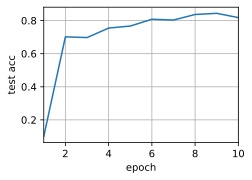

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

By keeping the batch size and learning rate unchanged and changing the number of GPUs to 2, we can see that the improvement in test accuracy is roughly the same as in the results from the previous experiment. In terms of the optimization algorithms, they are identical. Unfortunately there is no meaningful speedup to be gained here: the model is simply too small; moreover we only have a small dataset, where our slightly unsophisticated approach to implementing multi-GPU training suffered from significant Python overhead. We will encounter more complex models and more sophisticated ways of parallelization going forward. Let us see what happens nonetheless for Fashion-MNIST.


test acc: 0.82, 2.2 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


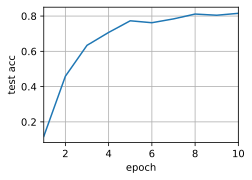

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## Summary

* There are multiple ways to split deep network training over multiple GPUs. We could split them between layers, across layers, or across data. The former two require tightly choreographed data transfers. Data parallelism is the simplest strategy.
* Data parallel training is straightforward. However, it increases the effective minibatch size to be efficient.
* Data is split across multiple GPUs, each GPU executes its own forward and backward operation and subsequently gradients are aggregated and results broadcast back to the GPUs.
* Large minibatches may require a slightly increased learning rate.

## Exercises

1. When training on multiple GPUs, change the minibatch size from $b$ to $k \cdot b$, i.e., scale it up by the number of GPUs.
1. Compare accuracy for different learning rates. How does it scale with the number of GPUs.
1. Implement a more efficient allreduce that aggregates different parameters on different GPUs (why is this more efficient in the first place).
1. Implement multi-GPU test accuracy computation.


[Discussions](https://discuss.d2l.ai/t/1669)
